## Demo: Stage1 processing for mooring data

Read the original raw files and convert to netCDF.  None to minimal additional processing.

In [27]:
import os

import yaml
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime

from ctd_tools.readers import SbeCnvReader, RbrRskAutoReader, RbrMatlabReader, NortekAsciiReader, SbeAsciiReader, RbrAsciiReader, AdcpMatlabReader
from ctd_tools.writers import NetCdfWriter
from ctd_tools.plotters import TimeSeriesPlotter

In [ ]:
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'
def stage1_mooring(mooring_name, basedir=None, output_path=None):
    '''
    Process a single mooring's data.

    The default output_path will be a subdirectory from the basedir as:
    basedir + moor/proc/mooring_name/instrument/

    To override this, input a full path for the output_path, but note that
    from the output path, the files will arrive in:
    output_path + mooring_name/instrument/

    Performs basic loading from the original data file (as specified in
    the YAML "filename").  It will look for this file in:
    basedir + moor/raw/instrument/

    Outfiles will be named: mooringname_serial_raw.nc
    '''
    if output_path is None:
        output_path = basedir + 'moor/proc/' + mooring_name
    moor_yaml = output_path + '/' + mooring_name + '.mooring.yaml'

    # Set up log file
    log_time = datetime.now().strftime('%Y%m%dT%H')
    log_file = os.path.join(output_path, f"{mooring_name}_{log_time}_stage1.mooring.log")
    def log_print(*args, **kwargs):
        print(*args, **kwargs)
        with open(log_file, 'a') as lf:
            print(*args, **kwargs, file=lf)

    log_print(mooring_name)
    with open(moor_yaml, 'r') as f:
        yaml_data = yaml.safe_load(f)

    indir = basedir + yaml_data['directory']
    dir_file = yaml_data['directory']
    for i in yaml_data['instruments']:
        readflag = False
        if 'filename' in i:
            infile_for_log = dir_file + i['instrument'] +'/'+i['filename']
            infile = indir + i['instrument'] + '/' + i['filename']
            out_inst_dir = output_path + '/' + i['instrument'] + '/'
            if not os.path.exists(out_inst_dir):
                os.makedirs(out_inst_dir)
                log_print(f"Created directory: {out_inst_dir}")

            # Cycle through reader types. Note that the SBE reader adds extra variables. Delete these.
            try:
                remove_vars = []
                remove_coords = []
                if i['file_type'] == 'sbe-cnv':
                    reader = SbeCnvReader(infile)
                    readflag = True
                    remove_vars = ['potential_temperature', 'julian_days_offset', 'density']
                    remove_coords = ['depth', 'latitude', 'longitude']
                elif i['file_type'] == 'nortek-aqd':
                    header_path = indir + i['instrument'] + '/' + i['header']
                    reader = NortekAsciiReader(infile, header_file_path=header_path)
                    readflag = True
                elif i['file_type'] == 'sbe-asc':
                    reader = SbeAsciiReader(infile)
                    readflag = True
                    remove_vars = ['potential_temperature', 'julian_days_offset', 'density']
                    remove_coords = ['depth', 'latitude', 'longitude']
                elif i['file_type'] == 'rbr-rsk':
                    reader = RbrRskAutoReader(infile)
                    readflag = True
                elif i['file_type'] == 'rbr-matlab':
                    reader = RbrMatlabReader(infile)
                    readflag = True
                elif i['file_type'] == 'rbr-dat':
                    reader = RbrAsciiReader(infile)
                    readflag = True
                elif i['file_type'] == 'adcp-matlab':
                    reader = AdcpMatlabReader(infile)
                    readflag = True
            except AttributeError as e:
                log_print(f"EXCEPT: Error reading file {infile_for_log}: {e}")
                continue

            def find_known_tag(fname, tags=("_000", "_001", "_002")):
                fname = str(fname)
                tag = ''
                for t in tags:
                    if t in fname:
                        tag = t
                return tag

            if readflag:
                tag1 = find_known_tag(i['filename'])
                if i['file_type'] == 'adcp-matlab':
                    tag1 = tag1
                else:
                    tag1 = ''
                output_file = out_inst_dir + mooring_name + "_" + str(i['serial']) + tag1 + '_raw.nc'
                outfile_for_log = output_file.replace(basedir, '')
                if not os.path.exists(output_file):
                    log_print(f"-->   Processing {i['instrument']}: {infile_for_log}")
                    log_print(f"Creating output file: {outfile_for_log}")

                    # Read the data into an xarray dataset
                    dataset = reader.get_data()
                    if remove_vars:
                        for var in remove_vars:
                            if var in dataset.variables:
                                log_print(f"Removing variable: {var}")
                                dataset = dataset.drop_vars(var)
                    if remove_coords:
                        for coord in remove_coords:
                            if coord in dataset.coords:
                                log_print(f"Removing coordinate: {coord}")
                                dataset = dataset.drop_vars(coord)

                    # Get parameters from yaml
                    # Global attributes
                    dataset.attrs['mooring_name'] = yaml_data['name']
                    dataset.attrs['waterdepth'] = yaml_data['waterdepth']
                    dataset.attrs['longitude'] = yaml_data.get('longitude', 0.0)
                    dataset.attrs['latitude'] = yaml_data.get('latitude', 0.0)
                    dataset.attrs['deployment_latitude'] = yaml_data.get('deployment_latitude', '00 00.000 N')
                    dataset.attrs['deployment_longitude'] = yaml_data.get('deployment_longitude', '000 00.000 W')
                    dataset.attrs['deployment_time'] = yaml_data.get('deployment_time','YYYY-mm-ddTHH:MM:ss')
                    dataset.attrs['seabed_latitude'] = yaml_data.get('seabed_latitude', '00 00.000 N')
                    dataset.attrs['seabed_longitude'] = yaml_data.get('seabed_longitude', '000 00.000 W')
                    dataset.attrs['recovery_time'] = yaml_data.get('recovery_time', 'YYYY-mm-ddTHH:MM:ss')

                    dataset['serial_number'] = i.get('serial',0)
                    dataset['InstrDepth'] = i.get('depth',0)
                    dataset['instrument'] = i.get('instrument','Unknown')
                    dataset['clock_offset'] = i.get('clock_offset', 0)
                    dataset['clock_offset'].attrs['units'] = 's'
                    if 0:
                        # Applying clock offsets shouldn't really happen until *_use.nc is created
                        dataset['time'] = dataset['time'] + np.timedelta64(int(dataset['clock_offset'].values), 's')

                    dataset['start_time'] = i.get('start_time', dataset.attrs['deployment_time'])
                    dataset['end_time'] = i.get('end_time', dataset.attrs['recovery_time'])

                    writer = NetCdfWriter(dataset)
                    writer.write(
                        output_file,
                        optimize=True,
                        drop_derived=False,  # drops vars with attrs["derived"] == True (e.g., z)
                        uint8_vars=[
                            "correlation_magnitude", "echo_intensity", "status", "percent_good",
                            "bt_correlation", "bt_amplitude", "bt_percent_good",
                        ],
                        float32_vars=[  # optional explicit list; float32=True already covers floats generically
                            "eastward_velocity", "northward_velocity", "upward_velocity",
                            "temperature", "salinity", "pressure", "pressure_std", "depth", "bt_velocity",
                        ],
                        chunk_time=3600,  # 1-hour chunks if you have ~1 Hz ensembles; adjust as needed
                        complevel=5,
                        quantize=3,
                    )
                else:
                    # Delete output file
                    #os.remove(output_file)
                    log_print(f"OUTFILE EXISTS: Skipping   {outfile_for_log}.")
            else:
                log_print(f"READER: No valid readers:  {infile_for_log}.")
        else:
            fname_for_log2 = dir_file + i['instrument'] +'/'+str(i['serial'])
            log_print(f"FILENAME MISSING: Skipping {i['instrument']}:{fname_for_log2}.  YAML is missing 'filename'.")

In [29]:

basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'
output_path = basedir + 'moor/proc/'

moorlist = ['ds2_X_2012','ds2_X_2017','ds2_X_2018',
            'ds8_1_2012','ds9_1_2012','ds10_1_2012', 'ds11_1_2012','ds12_1_2012',
            'ds13_1_2012','ds14_1_2012','ds15_1_2012','ds16_1_2012','ds17_1_2012',
            'ds19_1_2012','ds18_1_2012','ds28_1_2017',
            'dsA_1_2018','dsB_1_2018','dsC_1_2018', 'dsD_1_2018','dsE_1_2018','dsF_1_2018',
            'dsM1_1_2017','dsM2_1_2017','dsM3_1_2017','dsM4_1_2017','dsM5_1_2017']
moorlist = ['dsA_1_2018','dsB_1_2018','dsC_1_2018', 'dsD_1_2018','dsE_1_2018','dsF_1_2018']
moorlist = ['dsC_1_2018']
for idx, name1 in enumerate(moorlist):
    stage1_mooring(name1, basedir=basedir)

INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606368_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05607091_2018_08_27.cnv


dsC_1_2018
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606368_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606391_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606393_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05607091_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606391_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606407_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606404_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606393_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606407_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606406_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606392_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606404_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606406_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe16/DSC18_sbe16_1167efw1.cnv
INFO:pycnv:Dates computed based on timeS


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606392_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
type of depth is <class 'numpy.ndarray'>
xarray data has {'temperature': array([10.5636, 10.5393, 10.5644, ...,  4.4012,  4.2977, -5.0182],
      shape=(28540,)), 'salinity': array([ 0.    ,  0.    ,  0.    , ..., 34.9539,  0.    ,  1.867 ],
      shape=(28540,)), 'conductivity': array([-2.8600000e-04, -2.8600000e-04, -2.8600000e-04, ...,
        3.3306247e+01, -1.0245620e+00,  1.3777930e+00], shape=(28540,)), 'pressure': array([ 1.099000e+00,  1.103000e+00,  1.109000e+00, ...,  9.630590e+02,
       -5.148866e+03, -5.111398e+03], shape=(28540,)), 'timeS': array([0.0000e+00, 2.0000e+01, 4.0000e+01, ..., 5.7074e+05, 5.7076e+05,
       5.7078e+05], shape=(28540,))}
-->   Processing sbe16: moor/raw/msm76_2018/sbe16/DSC18_sbe16_1167efw1.cnv
Creating output file: moor/proc/dsC_1_2018/sbe16/dsC_1_2018_1167_raw.nc
Removing 

/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:93: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(max(1, min(ds.dims[d], int(chunk_time))))
/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:93: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(max(1, min(ds.dims[d], int(chunk_time))))
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05607090_2018_08_27.cnv


-->   Processing aquadopp: moor/raw/msm76_2018/aquadopp/DSC18_477102.dat
Creating output file: moor/proc/dsC_1_2018/aquadopp/dsC_1_2018_4771_raw.nc


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606395_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606367_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05607090_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606395_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606371_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606372_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606367_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606371_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/microcat/DSC18_SBE37SM_RS232_03715176_2018_08_26efw1.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606372_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv:Dates computed based on start_date and time_interval


Date
Computing date
type of depth is <class 'numpy.ndarray'>
xarray data has {'temperature': array([20.0331, 20.0329, 20.0325, ..., 19.698 , 19.6992, 19.7006],
      shape=(124610,)), 'salinity': array([0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ], shape=(124610,)), 'conductivity': array([ 0.000408,  0.00038 ,  0.00038 , ..., -0.00051 , -0.00051 ,
       -0.000539], shape=(124610,)), 'pressure': array([0.191, 0.196, 0.197, ..., 0.156, 0.168, 0.168], shape=(124610,)), 'julian_days_offset': array([224.333345, 224.333461, 224.333576, ..., 238.755451, 238.755567,
       238.755683], shape=(124610,))}


/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:93: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(max(1, min(ds.dims[d], int(chunk_time))))
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606408_2018_08_27.cnv


OUTFILE EXISTS: Skipping   moor/proc/dsC_1_2018/microcat/dsC_1_2018_15176_raw.nc.
-->   Processing aquadopp: moor/raw/msm76_2018/aquadopp/DSC18_477401.dat
Creating output file: moor/proc/dsC_1_2018/aquadopp/dsC_1_2018_4774_raw.nc


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606403_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606398_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606408_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606403_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606400_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606396_2018_08_27.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606398_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606400_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606369_2018_08_27.cnv
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/microcat/DSC18_SBE37SM_RS232_03707516_2018_08_26efw1.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606396_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606369_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


INFO:pycnv:Dates computed based on start_date and time_interval


Date
Computing date
type of depth is <class 'numpy.ndarray'>
xarray data has {'temperature': array([20.0636, 20.0515, 20.0415, ..., 20.1192, 20.1199, 20.1427],
      shape=(124629,)), 'salinity': array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01], shape=(124629,)), 'conductivity': array([0.000939, 0.000877, 0.000877, ..., 0.000908, 0.000908, 0.000939],
      shape=(124629,)), 'pressure': array([-0.118, -0.118, -0.118, ..., -0.22 , -0.208, -0.208],
      shape=(124629,)), 'julian_days_offset': array([224.333345, 224.333461, 224.333576, ..., 238.75765 , 238.757766,
       238.757882], shape=(124629,))}


/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:93: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(max(1, min(ds.dims[d], int(chunk_time))))
INFO:pycnv: Opening file: /Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/sbe56/DSC18_SBE05606399_2018_08_27.cnv


OUTFILE EXISTS: Skipping   moor/proc/dsC_1_2018/microcat/dsC_1_2018_7516_raw.nc.
-->   Processing aquadopp: moor/raw/msm76_2018/aquadopp/DSC18_905701.dat
Creating output file: moor/proc/dsC_1_2018/aquadopp/dsC_1_2018_9057_raw.nc


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSC18_SBE05606399_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'


/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/aquadopp/DSC18_477102.hdr
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/aquadopp/DSC18_477102.dat


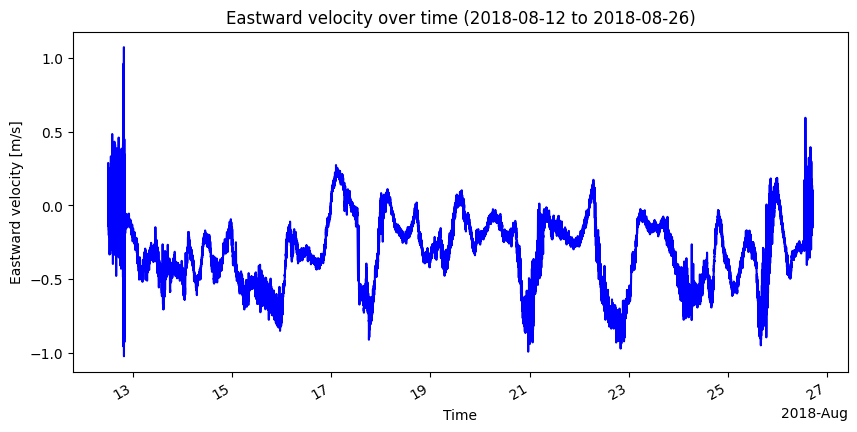

<xarray.Dataset> Size: 5MB
Dimensions:          (time: 20462)
Coordinates:
  * time             (time) datetime64[ns] 164kB 2018-08-12T12:00:00 ... 2018...
Data variables: (12/27)
    Month            (time) int64 164kB 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    Day              (time) int64 164kB 12 12 12 12 12 12 ... 26 26 26 26 26 26
    Year             (time) int64 164kB 2018 2018 2018 2018 ... 2018 2018 2018
    Hour             (time) int64 164kB 12 12 12 12 12 12 ... 16 16 16 17 17 17
    Minute           (time) int64 164kB 0 1 2 3 4 5 6 7 ... 55 56 57 58 59 0 1 2
    Second           (time) int64 164kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ...               ...
    Pressure_1       (time) float64 164kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temperature      (time) float64 164kB 19.95 19.96 19.96 ... 18.77 18.79
    Analog input 1   (time) int64 164kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    Analog input 2   (time) int64 164kB 15212 15212 15212 ... 15179 15179 15180
    Speed            (time) float64 164kB 0.18 0.288 0.091 ... 0.134 0.105 0.151
    Direction        (time) float64 164kB 38.46 89.2 16.64 ... 264.8 99.28 143.9

In [30]:
#FileNotFoundError: [Errno 2] No such file or directory: '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/adcp/DSF18_RDI_000_14971_001.mat'

## Try a plotter on a raw file
rawdir = basedir + 'moor/raw/msm76_2018/'
instrument = 'aquadopp'
data_dir = rawdir + instrument
fname = 'DSC18_477102.dat'
filename = data_dir + '/' + fname
header_file = data_dir + '/' + fname[0:-4] + '.hdr'
print(header_file)
print(filename)

#output_path = basedir + 'moor/proc/dsC_1_2018/aquadopp/' + fname[0:-4] + '.nc'
reader = NortekAsciiReader(filename,header_file_path=header_file)
dataset = reader.get_data()
plotter = TimeSeriesPlotter(dataset)
plotter.plot(parameter_name='east_velocity')

dataset

/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/raw/msm76_2018/adcp/DS0218_RDI_000_24289.mat


<xarray.Dataset> Size: 1GB
Dimensions:                (bin: 40, time: 172829, beam: 4)
Coordinates:
  * time                   (time) datetime64[ns] 1MB 2018-08-15T17:00:06.7600...
  * bin                    (bin) int64 320B 1 2 3 4 5 6 7 ... 35 36 37 38 39 40
    range                  (bin) float64 320B 12.17 20.17 28.17 ... 316.2 324.2
    z                      (bin, time) float64 55MB 11.17 10.17 ... 322.4 323.3
Dimensions without coordinates: beam
Data variables: (12/24)
    east_velocity          (bin, time) float64 55MB 0.002 0.015 ... nan nan
    north_velocity         (bin, time) float64 55MB 0.037 0.024 ... nan nan
    up_velocity            (bin, time) float64 55MB -0.244 -0.293 ... nan nan
    depth                  (time) float64 1MB 1.0 2.0 1.6 1.9 ... 0.8 1.8 0.9
    pressure               (time) float64 1MB 0.923 2.06 0.464 ... 1.183 0.115
    ensemble_number        (time) float64 1MB 1.0 2.0 ... 1.728e+05 1.728e+05
    ...                     ...
    percent_good           (bin, beam, time) float64 221MB 100.0 100.0 ... 0.0
    bt_range               (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_velocity            (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_correlation         (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_amplitude           (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_percent_good        (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/21)
    Conventions:                            CF-1.8
    title:                                  ADCP (RDI/Teledyne Workhorse) tim...
    source:                                 ADCP MATLAB export (adcp struct)
    instrument_type:                        wh-adcp
    beam_angle:                             20.0
    beam_frequency_kHz:                     150.0
    ...                                     ...
    ranges_definition:                      cell center range from transducer...
    time_coverage_start:                    2018-08-15T17:00:06.760
    time_coverage_end:                      2019-08-10T18:24:06.759
    vertical_velocity_converted_from_cm_s:  false
    pressure_original_units:                Pa
    dropped_zero_mtime_samples:             1

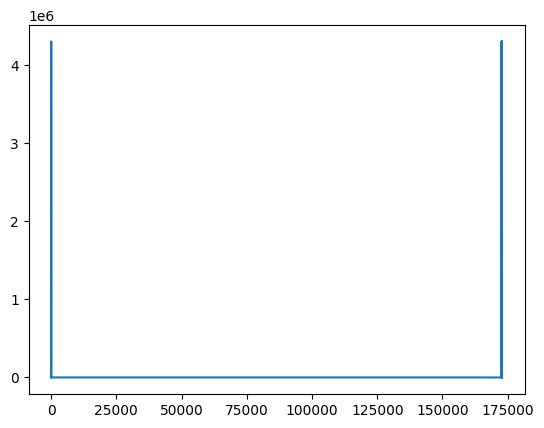

In [31]:
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'

## Try a plotter on a raw file
rawdir = basedir + 'moor/raw/msm76_2018/'
instrument = 'adcp'
data_dir = rawdir + instrument
fname = 'DS0218_RDI_000_24289.mat'
filename = data_dir + '/' + fname
print(filename)

#output_path = basedir + 'moor/proc/dsC_1_2018/aquadopp/' + fname[0:-4] + '.nc'
reader = AdcpMatlabReader(filename)
dataset = reader.get_data()
#plotter = TimeSeriesPlotter(dataset)
#plotter.plot(parameter_name='east_velocity')
plt.plot(dataset.pressure)
dataset

In [32]:
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/'
procdir = 'proc/dsC_1_2018/'

instrument = 'aquadopp'
fname = 'DSC18_905701.nc'
fname2 = 'dsC_1_2018_9057_raw.nc'

ds1 = xr.open_dataset(basedir+procdir+instrument+'/'+fname)
ds2 = xr.open_dataset(basedir+procdir+instrument+'/'+fname2)


plt.plot(ds1.time, ds1.east_velocity, label='east_velocity')
plt.plot(ds2.time, ds2.east_velocity, ':r',label='east_velocity2')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsC_1_2018/aquadopp/DSC18_905701.nc'

In [ ]:
ds2

<xarray.Dataset> Size: 3MB
Dimensions:          (time: 20492)
Coordinates:
  * time             (time) datetime64[ns] 164kB 2018-08-12T12:00:00 ... 2018...
Data variables: (12/31)
    Month            (time) int64 164kB ...
    Day              (time) int64 164kB ...
    Year             (time) int64 164kB ...
    Hour             (time) int64 164kB ...
    Minute           (time) int64 164kB ...
    Second           (time) int64 164kB ...
    ...               ...
    Speed            (time) float32 82kB ...
    Direction        (time) float32 82kB ...
    serial_number    int64 8B ...
    InstrDepth       int64 8B ...
    instrument       <U8 32B ...
    clock_offset     int64 8B ...
Attributes:
    mooring_name:  dsC_1_2018
    waterdepth:    1145
    longitude:     -29.32
    latitude:      65.46

In [ ]:

filenames=['dsM4_1_2017_7513_raw.nc','dsM4_1_2017_7517_raw.nc']
# Now try loading all netcdf files in the proc directory
proc_dir = basedir + 'moor/proc/dsM4_1_2017/microcat/'
for file in os.listdir(proc_dir):
    if file.endswith('.nc'):
        file_path = os.path.join(proc_dir, file)
        print(f"Loading netCDF file: {file_path}")
        dataset = xr.open_dataset(file_path)
        # You can add more processing or analysis here
        print(list(dataset.data_vars))  # Print variable names in the dataset
        print(list(dataset.attrs))

        if 'temperature' in dataset.data_vars:
            fig, ax = plt.subplots(figsize=(8, 2))
            ax.plot(dataset['time'], dataset['temperature'], label='Temperature')
            ax.set_ylabel('Temperature (°C)')
            ax.set_title(dataset.attrs['mooring_name'] + ': ' + dataset['instrument'].values + ' ' + str(dataset['serial_number'].values))
            ax.set_xlabel('Time')
            ax.legend()
            ax.grid()

# Save the plot to a png
            fig.savefig(f"{dataset.attrs['mooring_name']}_{dataset['instrument'].values}_T.png")
            plt.tight_layout()
            plt.show()
